# Implementation of Variational AutoEncoder (VAE)

_Modified from Jackson Kang's notebook available [here](https://github.com/Jackson-Kang/Pytorch-VAE-tutorial):_

    VAE from "Auto-Encoding Variational Bayes" (2014, D.P. Kingma et. al.)
    Kernel-author: Jackson Kang @ Deep-learning Lab. (Handong Global University, S.Korea)

In [1]:
#note if using for first time with conda, will need to download pytorch using conda prompt

import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from torchvision.utils import save_image, make_grid

In [1]:
# Model Hyperparameters
# Might be overkill for our purposes, but we could look into using Ray Tune to optimize our hyperparameter selection.

dataset_path = r'C:/Users/Aidan/Documents/Winter_2023/BE177B/Code/Pytorch-VAE-tutorial/datasets' #where we want to store everything

# if you have nvida graphics card, will greatly accelerate training... I do not, so cuda = False :(
cuda = False
DEVICE = torch.device("cuda" if cuda else "cpu")
batch_size = 100   # how many images we feed each epoch

# these are all the dimensions of the layres
x_dim  = 784       # (flattened) dimensionality of our input space. Determined by dataset. MINST is 28x28 matrix --> 728 flattened
hidden_dim = 400   # dimensionality of our encoder NN
latent_dim = 200   # dimensionality of encoded space

lr = 1e-3 #tolerance for linear regression
epochs = 30 #number of training rounds

NameError: name 'torch' is not defined

###    Step 1. Load Dataset

In [4]:
from torchvision.datasets import MNIST # in practice, we will be pulling the dataset from either the artifical data I made, or experimental data from data team
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

MNIST is imported as a PyTorch dataset which stores the samples and their corresponding labels. To work with it
we use the funciton DataLoader to wrap it in an iterable.


In [7]:
mnist_transform = transforms.Compose([
        transforms.ToTensor(),
]) 
# compose allows us to preform multiple transforms successivley (which we do not do here) 
# ToTensor converts the image or numpy array to a floatTensor and normalizes the matrix to 0-1 (for most encodings)

kwargs = {'num_workers': 1, 'pin_memory': True} #if we were working on cloud (i.e. with AWS) this would matter. We don't need this

train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs) # shuffle for more robust, order independet training
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False, **kwargs) # no need to shuffle here, will get same result

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting C:\Users\Aidan/datasets\MNIST\raw\train-images-idx3-ubyte.gz to C:\Users\Aidan/datasets\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting C:\Users\Aidan/datasets\MNIST\raw\train-labels-idx1-ubyte.gz to C:\Users\Aidan/datasets\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting C:\Users\Aidan/datasets\MNIST\raw\t10k-images-idx3-ubyte.gz to C:\Users\Aidan/datasets\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting C:\Users\Aidan/datasets\MNIST\raw\t10k-labels-idx1-ubyte.gz to C:\Users\Aidan/datasets\MNIST\raw



### Step 2. Define the Variational AutoEncoder (VAE)

This VAE uses a Gaussian (normal) distribution. I would guess this is good for our dataset too, but we also could look into using some other distribution.

In [8]:
"""
    A simple implementation of Gaussian MLP Encoder and Decoder
"""

class Encoder(nn.Module): #we must define our encoder as a subclass of the provided PyTorch neural network
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
        self.training = True
        
    def forward(self, x):
        h_       = self.LeakyReLU(self.FC_input(x))
        h_       = self.LeakyReLU(self.FC_input2(h_))
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                     # encoder produces mean and log of variance 
                                                       #             (i.e., parateters of simple tractable normal distribution "q"
        
        return mean, log_var

In [9]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h     = self.LeakyReLU(self.FC_hidden(x))
        h     = self.LeakyReLU(self.FC_hidden2(h))
        
        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat
        

In [10]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)        # sampling epsilon        
        z = mean + var*epsilon                          # reparameterization trick
        return z
        
                
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat            = self.Decoder(z)
        
        return x_hat, mean, log_var

In [13]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

### Step 3. Define Loss function (reprod. loss) and optimizer

In [14]:
from torch.optim import Adam

BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD


optimizer = Adam(model.parameters(), lr=lr)

### Step 4. Train Variational AutoEncoder (VAE)

In [18]:
import time 

print("---VAE Training---")
model.train()

for epoch in range(epochs):

    startTime = time.perf_counter()
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)
        
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()
    timediff = (time.perf_counter()-startTime)
    print("\tEpoch {} complete \tAverage Loss: {} \tTraining time: {} ".format(epoch+1, overall_loss / (batch_idx*batch_size), timediff))
    
print("Finish!!")

---VAE Training---
	Epoch 1 complete 	Average Loss: 109.49537446851524 	Training time: 12.360359400001471 
	Epoch 2 complete 	Average Loss: 107.81277779045806 	Training time: 12.4861877000003 
	Epoch 3 complete 	Average Loss: 106.70760579155363 	Training time: 13.01796370000011 
	Epoch 4 complete 	Average Loss: 105.93200638759912 	Training time: 13.732519899998806 
	Epoch 5 complete 	Average Loss: 105.13631193590881 	Training time: 12.985668900000746 
	Epoch 6 complete 	Average Loss: 104.64241538632095 	Training time: 12.70972729999994 
	Epoch 7 complete 	Average Loss: 104.08520333368114 	Training time: 14.221607800000129 
	Epoch 8 complete 	Average Loss: 103.7491527708942 	Training time: 15.21710080000048 
	Epoch 9 complete 	Average Loss: 103.32437511412249 	Training time: 14.938389099999767 
	Epoch 10 complete 	Average Loss: 102.9677155610914 	Training time: 14.930015699999785 
	Epoch 11 complete 	Average Loss: 102.56694269094324 	Training time: 14.738728500000434 
	Epoch 12 complete

### Step 5. Generate images from test dataset

In [19]:
import matplotlib.pyplot as plt

In [20]:
model.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)
        
        x_hat, _, _ = model(x)

        break

  0%|          | 0/100 [00:01<?, ?it/s]


In [21]:
def show_image(x, idx):
    x = x.view(batch_size, 28, 28)

    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy())

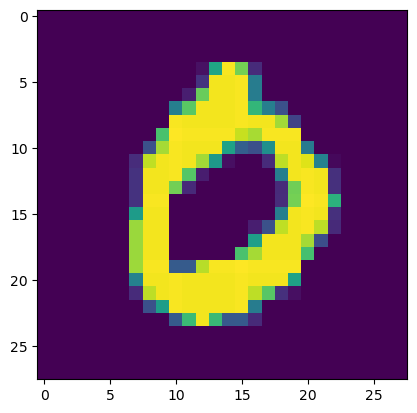

In [26]:
show_image(x, idx=3)

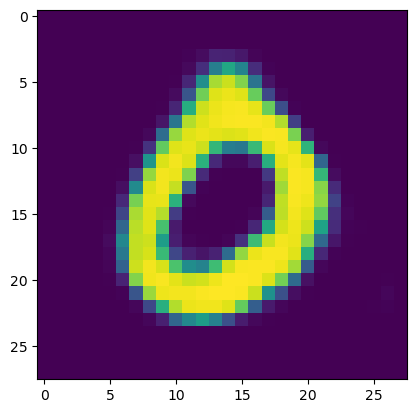

In [25]:
show_image(x_hat, idx=3)

### Step 6. Generate image from noise vector

**Please note that this is not the correct generative process.**

* Even if we don't know exact p(z|x), we can generate images from noise, since the loss function of training VAE regulates the q(z|x) (simple and tractable posteriors) must close enough to N(0, I). If q(z|x) is close to N(0, I) "enough"(but not tightly close due to posterior collapse problem), N(0, I) may replace the encoder of VAE.

* To show this, I just tested with a noise vector sampled from N(0, I) similar with Generative Adversarial Network.

In [15]:
with torch.no_grad():
    noise = torch.randn(batch_size, latent_dim).to(DEVICE)
    generated_images = decoder(noise)

In [16]:
save_image(generated_images.view(batch_size, 1, 28, 28), 'generated_sample.png')

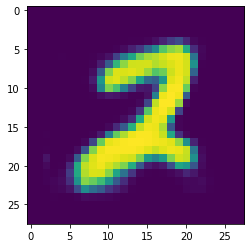

In [17]:
show_image(generated_images, idx=12)

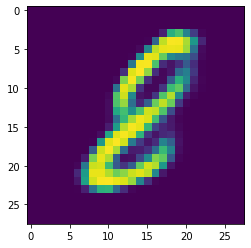

In [18]:
show_image(generated_images, idx=0)

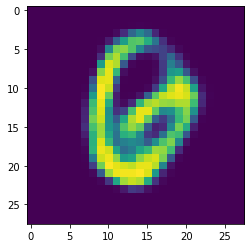

In [19]:
show_image(generated_images, idx=1)

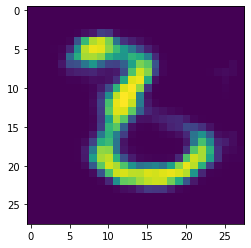

In [20]:
show_image(generated_images, idx=10)

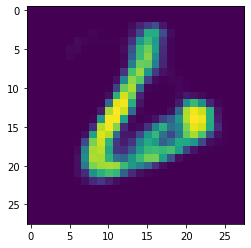

In [21]:
show_image(generated_images, idx=20)

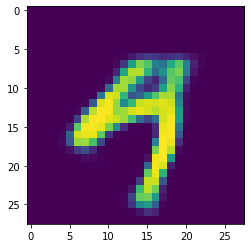

In [22]:
show_image(generated_images, idx=50)